In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

C:\Users\premvardhan\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import sqlite3
con = sqlite3.connect("final.sqlite")

In [6]:
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [8]:
cleaned_data.shape

(364171, 12)

In [9]:
# To randomly sample 10k points from both class

data_pos = cleaned_data[cleaned_data["Score"] == "positive"].sample(n = 10000)
data_neg = cleaned_data[cleaned_data["Score"] == "negative"].sample(n = 10000)
final_20k = pd.concat([data_pos, data_neg])
final_20k.shape

(20000, 12)

In [ ]:
final_20k["Time"] = pd.to_datetime(final_20k["Time"], unit = "s")
final_20k = final_20k.sort_values(by = "Time")

<h1>Bag of Word</h1>

In [114]:
# Fuction to compute k value
def k_classifier_brute(X_train, y_train):
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = "brute")
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[MSE.index(min(MSE))]
    print('\nThe optimal number of neighbors is %d.' % optimal_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("the misclassification error for each k value is : ", np.round(MSE,3))
    return optimal_k

In [117]:
# 40k data which will use to train model after vectorization
X = final_20k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (20000,)


In [118]:
# class label
y = final_20k["Score"]
print("shape of y:", y.shape)

shape of y: (20000,)


In [119]:
# split data into train and test where 70% data used to train model and 30% for test
# final_4000[:int(len(final_4000) * 0.75)], final_4000[int(len(final_4000) * 0.75):]
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape, x_test.shape)

(14000,) (14000,) (6000,)


In [120]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<14000x15608 sparse matrix of type '<class 'numpy.int64'>'
	with 451401 stored elements in Compressed Sparse Row format>

In [121]:
# Test Vectorizor
x_test = bow.transform(x_test)

In [122]:
x_test.shape

(6000, 15608)


The optimal number of neighbors is 27.


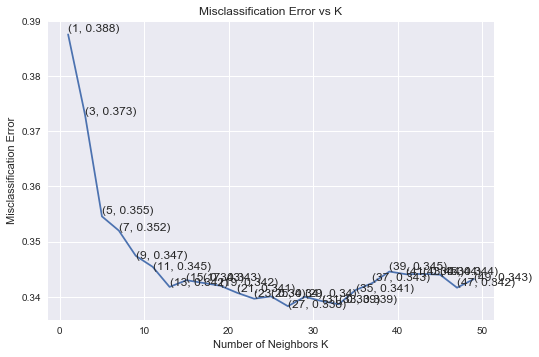

the misclassification error for each k value is :  [ 0.388  0.373  0.355  0.352  0.347  0.345  0.342  0.343  0.343  0.342
  0.341  0.34   0.34   0.338  0.34   0.339  0.339  0.341  0.343  0.345
  0.344  0.344  0.344  0.342  0.343]


27

In [123]:
# To choose optimal_k using brute force algorithm

optimal_k_bow = k_classifier_brute(X_train, y_train)
optimal_k_bow

In [124]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_optimal.predict(x_test)

In [125]:
# Accuracy on train data
train_acc_bow = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_bow)

Train accuracy 0.7005


In [126]:
# Error on train data
train_err_bow = 1-train_acc_bow
print("Train Error %f%%" % (train_err_bow))

Train Error 0.299500%


In [127]:
# evaluate accuracy on test data
acc_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc_bow))


The accuracy of the knn classifier for k = 47 is 66.300000%


In [128]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[1278, 1673],
       [ 349, 2700]])

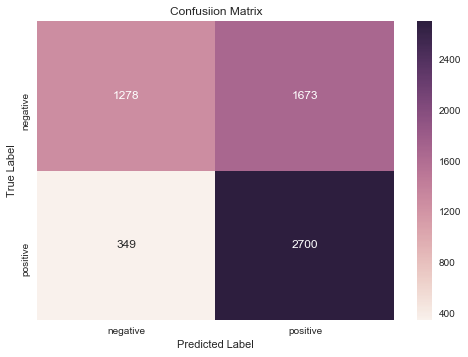

In [129]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [130]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.79      0.43      0.56      2951
   positive       0.62      0.89      0.73      3049

avg / total       0.70      0.66      0.64      6000



**Terminology**<br>

**true positives (TP):** We predicted +ve review, and review is also +ve.<br>
**true negatives (TN):** We predicted -ve, and review is also -ve.<br>
**false positives (FP):** We predicted +ve, but the review is not actually +ve.(Also known as a "Type I error.")<br>
**false negatives (FN):** We predicted -ve, but the review is actually +ve.(Also known as a "Type II error.")<br>


**confusion matrix described**<br>
In above confusion matrix(used to describe performence of classifier)

1. tn(true negative) = 1278, tp(true positive) = 2700, fn(false negative) = 349, fp(false positive) = 1673
2. And as it is shows in classification report overall accuracy(i.e. how often is the classifier correct?) = (tp+tn)/total = (2700+1278)/6000 = ~66%
3. And Overall error rate/misclassification rate or 1-accuracy(i.e. how often it is wrong?) --> (fn+fp)/total = (349+1673)/6000 = ~34%
4. precision --> When it predicts +ve, how often is it correct? = tp/predicted +ve = 2700/4373 = ~62%
5. True Positive rate(tpr)/recall --> When it is actually +ve, how often does it predict +ve? = tp/(real/true/actual +ve) = 2700/3049 = ~89%
6. Specificity(True Negative Rate)--> When it's actually no, how often does it predict no? = tn/actual negative = 1278/2951 = ~43%. The best specificity is 1.0, whereas the worst is 0.0 .
7. False Positive rate --> when it is actually -ve, how often does it predicted +ve = fp/actual-ve = 1673/2951 = ~57%
8. F1 score/F-score/F-measure is weighted avg of precision and recall(tpr).
9. support is number of elements in each class(+ve and -ve).

**Observations**</br>
1. From above figure(misclassification error vs optimal k) It is showing that classification error for each value of k, when k is increaseing the error is decreasing. For ex - if k = 1 then error = 38%, k = 2 error = 37% and so on.
2. As I tested our model on unseen data(test data) the accuracy is 66% when k = 47. 
3. In confusion matrix, It is clear that out of 6k unseen data-points classifier predict 4373 +ve and 1627 -ve class label but in real 3049 were +ve and 2951 were -ve.
4. In a nutshell we can say the generalization error is quite high means this model does not work well with unseen data.

<h1>Tf-Idf</h1>

In [131]:
# data
X = final_20k["CleanedText"]

In [132]:
# Target/class-label
y = final_20k["Score"]

In [176]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(14000,) (6000,) (14000,) (6000,)


In [177]:
from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer()
#tfidf_data = tfidf.fit_transform(final_4000["CleanedText"])
#tfidf_data
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<14000x352084 sparse matrix of type '<class 'numpy.float64'>'
	with 1787296 stored elements in Compressed Sparse Row format>

In [178]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(6000, 352084)


The optimal number of neighbors is 49.


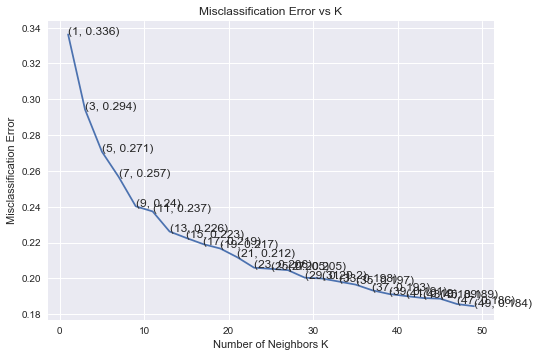

the misclassification error for each k value is :  [ 0.336  0.294  0.271  0.257  0.24   0.237  0.226  0.223  0.219  0.217
  0.212  0.206  0.205  0.205  0.2    0.2    0.198  0.197  0.193  0.191
  0.19   0.189  0.189  0.186  0.184]


49

In [179]:
# To choosing optimal_k

optimal_k_tfidf = k_classifier_brute(X_train, y_train)
optimal_k_tfidf

In [180]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [138]:
'''
from sklearn.model_selection import validation_curve
train_scores, test_scores = validation_curve(KneighborsClassifier(), X, y, cv = 10, scoring = "accuracy")
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
'''

'\nfrom sklearn.model_selection import validation_curve\ntrain_scores, test_scores = validation_curve(KneighborsClassifier(), X, y, cv = 10, scoring = "accuracy")\ntrain_scores_mean = np.mean(train_scores, axis=1)\ntrain_scores_std = np.std(train_scores, axis=1)\ntest_scores_mean = np.mean(test_scores, axis=1)\ntest_scores_std = np.std(test_scores, axis=1)\n'

In [181]:
# Accuracy on train data
train_acc_tfidf = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf)

Train accuracy 0.836428571429


In [182]:
# Error on train data
train_err_tfidf = 1-train_acc_tfidf
print("Train Error %f%%" % (train_err_tfidf))

Train Error 0.163571%


In [183]:
# evaluate accuracy
acc_tfidf = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc_tfidf))


The accuracy of the knn classifier for k = 49 is 81.216667%


In [184]:
#from sklearn.matrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[2346,  605],
       [ 522, 2527]])

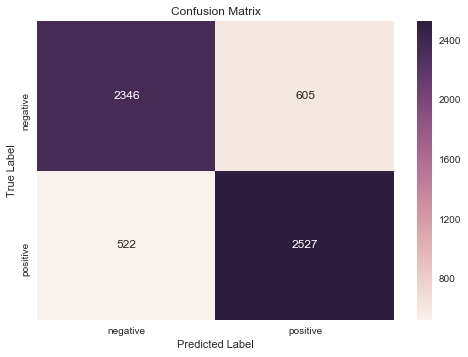

In [185]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [186]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.82      0.79      0.81      2951
   positive       0.81      0.83      0.82      3049

avg / total       0.81      0.81      0.81      6000



**Observations**
1. look at the bow observations for clarifying doubt.
2. In tfidf when the value of k = 49 which is quite high, accuracy is also good.
3. In a nutshell we can say this model works well with unseen data.

<h1> word2vec </h1>

In [187]:
# data
X = final_20k["Text"]
X.shape

(20000,)

In [188]:
# Target/class-label
y = final_20k["Score"]
y.shape

(20000,)

In [189]:
X_train, x_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.3)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(14000,) (6000,) (14000,) (6000,)


In [190]:
import re

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [191]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [192]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [193]:
w2v_model.wv.most_similar('like')

[('notice', 0.6277258992195129),
 ('awful', 0.6034363508224487),
 ('enjoy', 0.5972869396209717),
 ('ok', 0.583526074886322),
 ('disgusting', 0.5813804864883423),
 ('think', 0.5768690705299377),
 ('mean', 0.5754651427268982),
 ('gross', 0.5754641890525818),
 ('expect', 0.5734571814537048),
 ('horrible', 0.5628089308738708)]

In [194]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [195]:
w2v.shape

(7801, 50)

In [196]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [197]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [198]:
w2v_model.wv.most_similar('like')

[('overpower', 0.826438844203949),
 ('prefer', 0.7512593269348145),
 ('think', 0.7512395977973938),
 ('enjoy', 0.7508682608604431),
 ('even', 0.7381380796432495),
 ('smell', 0.7360379099845886),
 ('taste', 0.7204399108886719),
 ('chocolate', 0.7204398512840271),
 ('bitter', 0.7198981046676636),
 ('sweet', 0.7129392027854919)]

In [199]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [200]:
w2v.shape

(4887, 50)

<h1> Average Word2Vec </h1>

In [201]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

14000
50


In [202]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

6000
50


In [203]:
X_train = sent_vectors

In [204]:
x_test = sent_vectors_test


The optimal number of neighbors is 41.


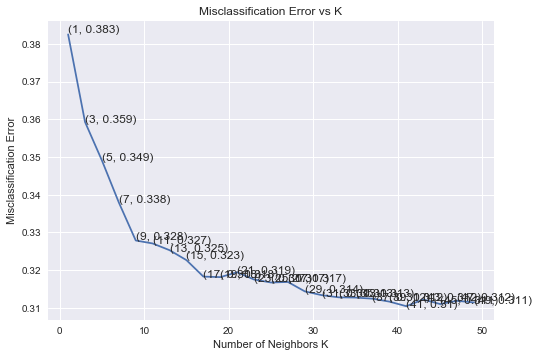

the misclassification error for each k value is :  [ 0.383  0.359  0.349  0.338  0.328  0.327  0.325  0.323  0.318  0.318
  0.319  0.317  0.317  0.317  0.314  0.313  0.313  0.313  0.312  0.312
  0.31   0.312  0.311  0.312  0.311]


41

In [205]:
optimal_k_avgw2v = k_classifier_brute(X_train, y_train)
optimal_k_avgw2v

In [206]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_avgw2v)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [207]:
# Accuracy on train data
train_acc_avgw2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_avgw2v)

Train accuracy 0.712642857143


In [208]:
# Error on train data
train_err_avgw2v = 1-train_acc_avgw2v
print("Train Error %f%%" % (train_err_avgw2v))

Train Error 0.287357%


In [209]:
# evaluate accuracy
acc_avg_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc_avg_w2v))


The accuracy of the knn classifier for k = 49 is 68.516667%


In [246]:
print("Test Error %f%%" %-(100-(acc_avg_w2v)))

Test Error -31.483333%


In [210]:
cm = confusion_matrix(y_test, pred)
cm

array([[2290,  687],
       [1202, 1821]])

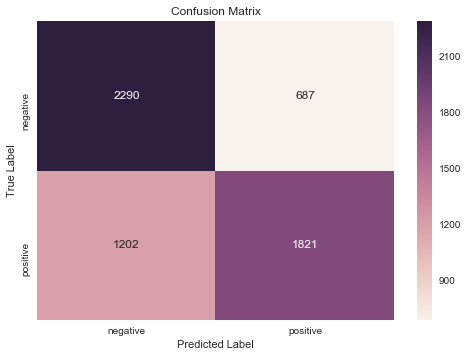

In [211]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [212]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.66      0.77      0.71      2977
   positive       0.73      0.60      0.66      3023

avg / total       0.69      0.69      0.68      6000



**Observations**

<h1> Tf-Idf weighted Word2Vec </h1>

In [213]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [214]:
len(tfidf_sent_vectors)

14000

In [215]:
X_train = tfidf_sent_vectors

In [216]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

C:\Users\premvardhan\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


In [217]:
len(tfidf_sent_vectors_test)

6000

In [218]:
x_test = tfidf_sent_vectors_test

In [219]:
X_train = np.nan_to_num(X_train)

In [220]:
x_test = np.nan_to_num(x_test)

In [92]:
#X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


The optimal number of neighbors is 5.


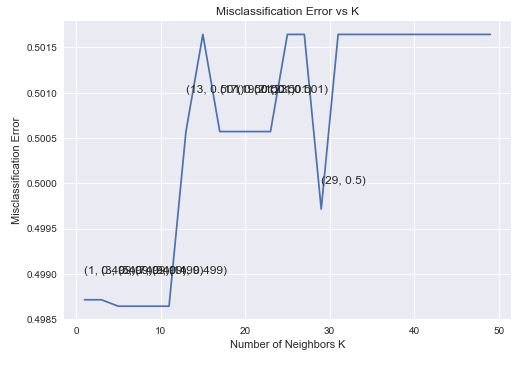

the misclassification error for each k value is :  [ 0.499  0.499  0.499  0.499  0.499  0.499  0.501  0.502  0.501  0.501
  0.501  0.501  0.502  0.502  0.5    0.502  0.502  0.502  0.502  0.502
  0.502  0.502  0.502  0.502  0.502]


5

In [221]:
optimal_k_tfidf_w2v = k_classifier_brute(X_train, y_train)
optimal_k_tfidf_w2v

In [222]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_tfidf_w2v)

# fitting the model
knn_optimal.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)
    
# predict the response
pred = knn_optimal.predict(x_test)

In [223]:
# Accuracy on train data
train_acc_tfidf_w2v = knn_optimal.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf_w2v)

Train accuracy 0.498357142857


In [224]:
# Error on train data
train_err_tfidf_w2v = 1-train_acc_tfidf_avgw2v
print("Train Error %f%%" % (train_err_tfidf_w2v))

Train Error 0.499143%


In [225]:
# evaluate accuracy
acc_tfidf_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc_tfidf_w2v))


The accuracy of the knn classifier for k = 49 is 50.383333%


In [247]:
print("Test Error %f%%" %-(100-(acc_tfidf_w2v)))

Test Error -49.616667%


In [227]:
cm = confusion_matrix(y_test, pred)
cm

array([[   0, 2977],
       [   0, 3023]])

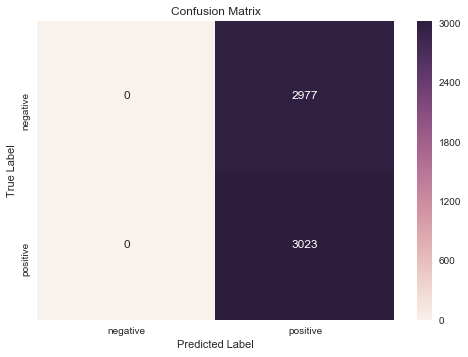

In [228]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [229]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00      2977
   positive       0.50      1.00      0.67      3023

avg / total       0.25      0.50      0.34      6000



C:\Users\premvardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Observations**
1. The tfidf_w2v model is looks like dumb model because it is biased towards majority class, as the total # of actual +ve class was 3023(true positive) and classifier predicted all points as +ve class.

**Conclusions**
1. As in "knn with tfidf" when k = 49 the accuracy is quite good than other models. In this model, train_error and test_error is low.
2. As we know when a model performs good on training data but poor performence on unseen data(test data)i.e. its dependent on training data only, tends towards overfits and when a model perform poor performence on training data and good performence on test data i.e. it fails to learn relationship in training data tends towards underfit. We need to balance between both i.e. reduce training error and reduce error between training and testing error.
3. Another concept bias vs variance is also related with underfitting and overfitting. when a model has high bias and low variance tend towards underfitting and its reverse- high variance and low bias called overfitting and we balanced using cross-validataion. As it is shown in below table where first three models have low trainig error and test error. But the accuracy it low which we can boost using some techniques.
3. There are lot more things to write here but for now that's all. Will look more in next excercise.

In [251]:
# model
models = pd.DataFrame({'Model': ['KNN with Bow', "KNN with TFIDF", "KNN with Avg_w2v", "KNN with tfidf_w2v"], 'Hyper Parameter(K)': [optimal_k_bow, optimal_k_tfidf, optimal_k_avgw2v, optimal_k_tfidf_w2v], 'Train Error': [train_err_bow, train_err_tfidf, train_err_avgw2v, train_err_tfidf_w2v], 'Test Error': [100-acc_bow, 100-acc_tfidf, 100-acc_avg_w2v, 100-acc_tfidf_w2v], 'Accuracy': [acc_bow, acc_tfidf, acc_avg_w2v, acc_tfidf_w2v]}, columns = ["Model", "Hyper Parameter(K)", "Train Error", "Test Error", "Accuracy"])
models.sort_values(by='Accuracy', ascending=False)

,Model,Hyper Parameter(K),Train Error,Test Error,Accuracy
1,KNN with TFIDF,49,0.163571,18.783333,81.216667
2,KNN with Avg_w2v,41,0.287357,31.483333,68.516667
0,KNN with Bow,27,0.299500,33.700000,66.300000
3,KNN with tfidf_w2v,5,0.499143,49.616667,50.383333
